In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

2024-05-07 16:52:30.453829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 16:52:30.453953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 16:52:30.582883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
filelist_trainx_ph2 = sorted(glob.glob('/kaggle/input/resized-segnet/resized_5000/trainx/*.jpg'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('/kaggle/input/resized-segnet/resized_5000/trainy/*.png'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

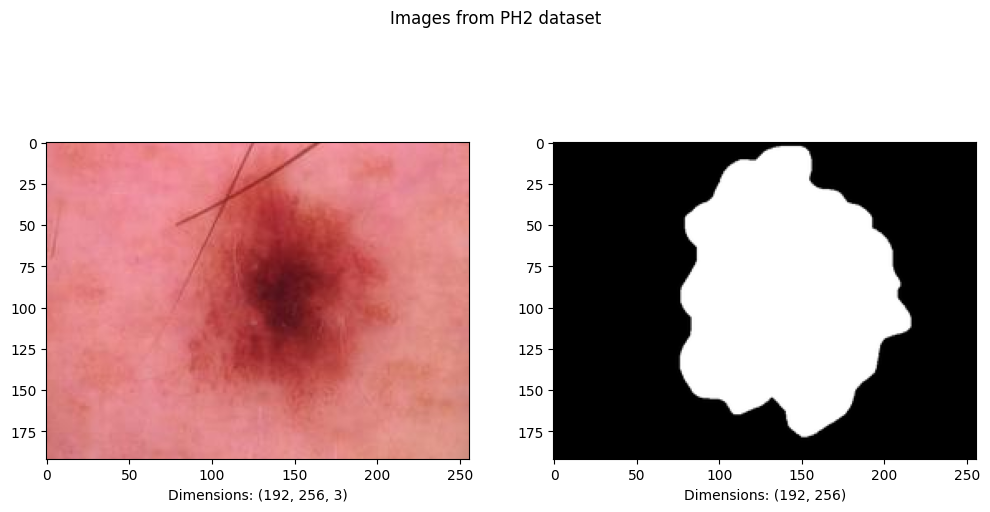

In [4]:
plt.figure(figsize=(12,6))
plt.suptitle("Images from HAM10000 dataset")
plt.subplot(1,2,1)
plt.imshow(X_train_ph2[0])
plt.xlabel("Dimensions: "+str(np.array(X_train_ph2[0]).shape))
plt.subplot(1,2,2)
plt.imshow(Y_train_ph2[0], plt.cm.binary_r)
plt.xlabel("Dimensions: "+str(np.array(Y_train_ph2[0]).shape))
plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

In [6]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [7]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [8]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [9]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [10]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [11]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [12]:
x_train, x_val, y_train, y_val = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.20, random_state = 101)

In [13]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 4000
Length of the Test Set       : 1250
Length of the Validation Set : 1000


In [58]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [59]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192, 256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save('/kaggle/working/' + savename)
    return model, hist

In [60]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 192, 256))
    axis = 1
else:
    inputs = Input((192, 256, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((192, 256))(conv_final)

In [61]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [62]:
model_unet = Model(inputs, pred, name="UNET_224")
model_unet.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coef,precision, recall, accuracy])

In [64]:
model_unet.load_weights('/kaggle/input/unet/tensorflow2/unet_100_pretrained/1/unet_100_epoch (1).h5')

In [66]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [67]:
from tensorflow.keras.optimizers import SGD
model_segnet = Model(inputs=img_input, outputs=pred)

model_segnet.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [68]:
model_segnet.load_weights('/kaggle/input/notebook7c53db0e77/retrain_segnet_150_ep.keras')

In [55]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res_unet = model_unet.evaluate(x_train, y_train, batch_size= 18)
res_segnet = model_segnet.evaluate(x_train, y_train, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res_unet = model_unet.evaluate(x_test, y_test, batch_size= 18)
res_segnet = model_segnet.evaluate(x_test, y_test, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res_unet = model_unet.evaluate(x_val, y_val, batch_size= 18)
res_segnet = model_segnet.evaluate(x_val, y_val, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6252 - dice_coef: 1.0126 - iou: 0.3344 - loss: 0.6656 - precision: 0.9236 - recall: 0.5982
223/223 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.6594 - dice_coef: 1.8257 - iou: 0.3104 - loss: -662.4490 - precision: 1.0694 - recall: 0.9904
_______________SegNet_____Unet____
IOU:       |   31.48  |   33.81  |
Dice Coef: |   189.02  |   102.02  |
Precision: |   104.28  |   93.05  |
Recall:    |   98.99  |   60.37  |
Accuracy:  |   79.71  |   77.81  |
Loss:      |   -6.94  |   66.19  |
________________________

-------------On Test  Set--------------------------

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6103 - dice_coef: 0.9755 - iou: 0.3174 - loss: 0.6826 - precision: 0.9100 - recall: 0.5769
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6200 - dice_coef: 1.5728 - iou: 0.2908 - loss: -524.7498 - preci

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


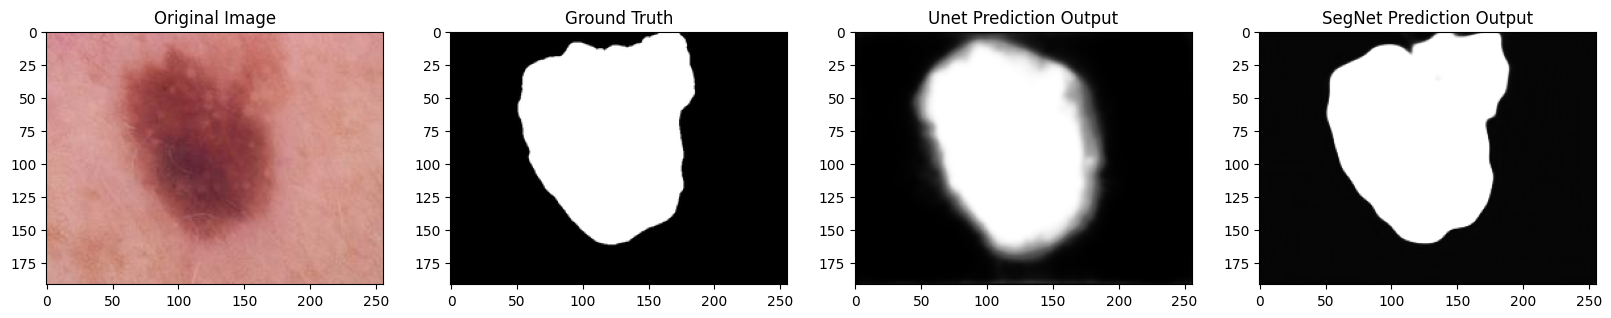

In [69]:
img_num = 49
img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

In [70]:
def enhance(img):
    sub1 = (model_unet.predict(img.reshape(1,192,256,3))).flatten()
    sub2 = (model_segnet.predict(img.reshape(1,192,256,3))).flatten()
    sub = sub1[:]
    for i in range(len(sub)):
        sub[i] = (sub1[i] + sub2[i])/2

        if sub[i] > 0.7:
            sub[i] = 1
        else:
            sub[i] = 0

    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


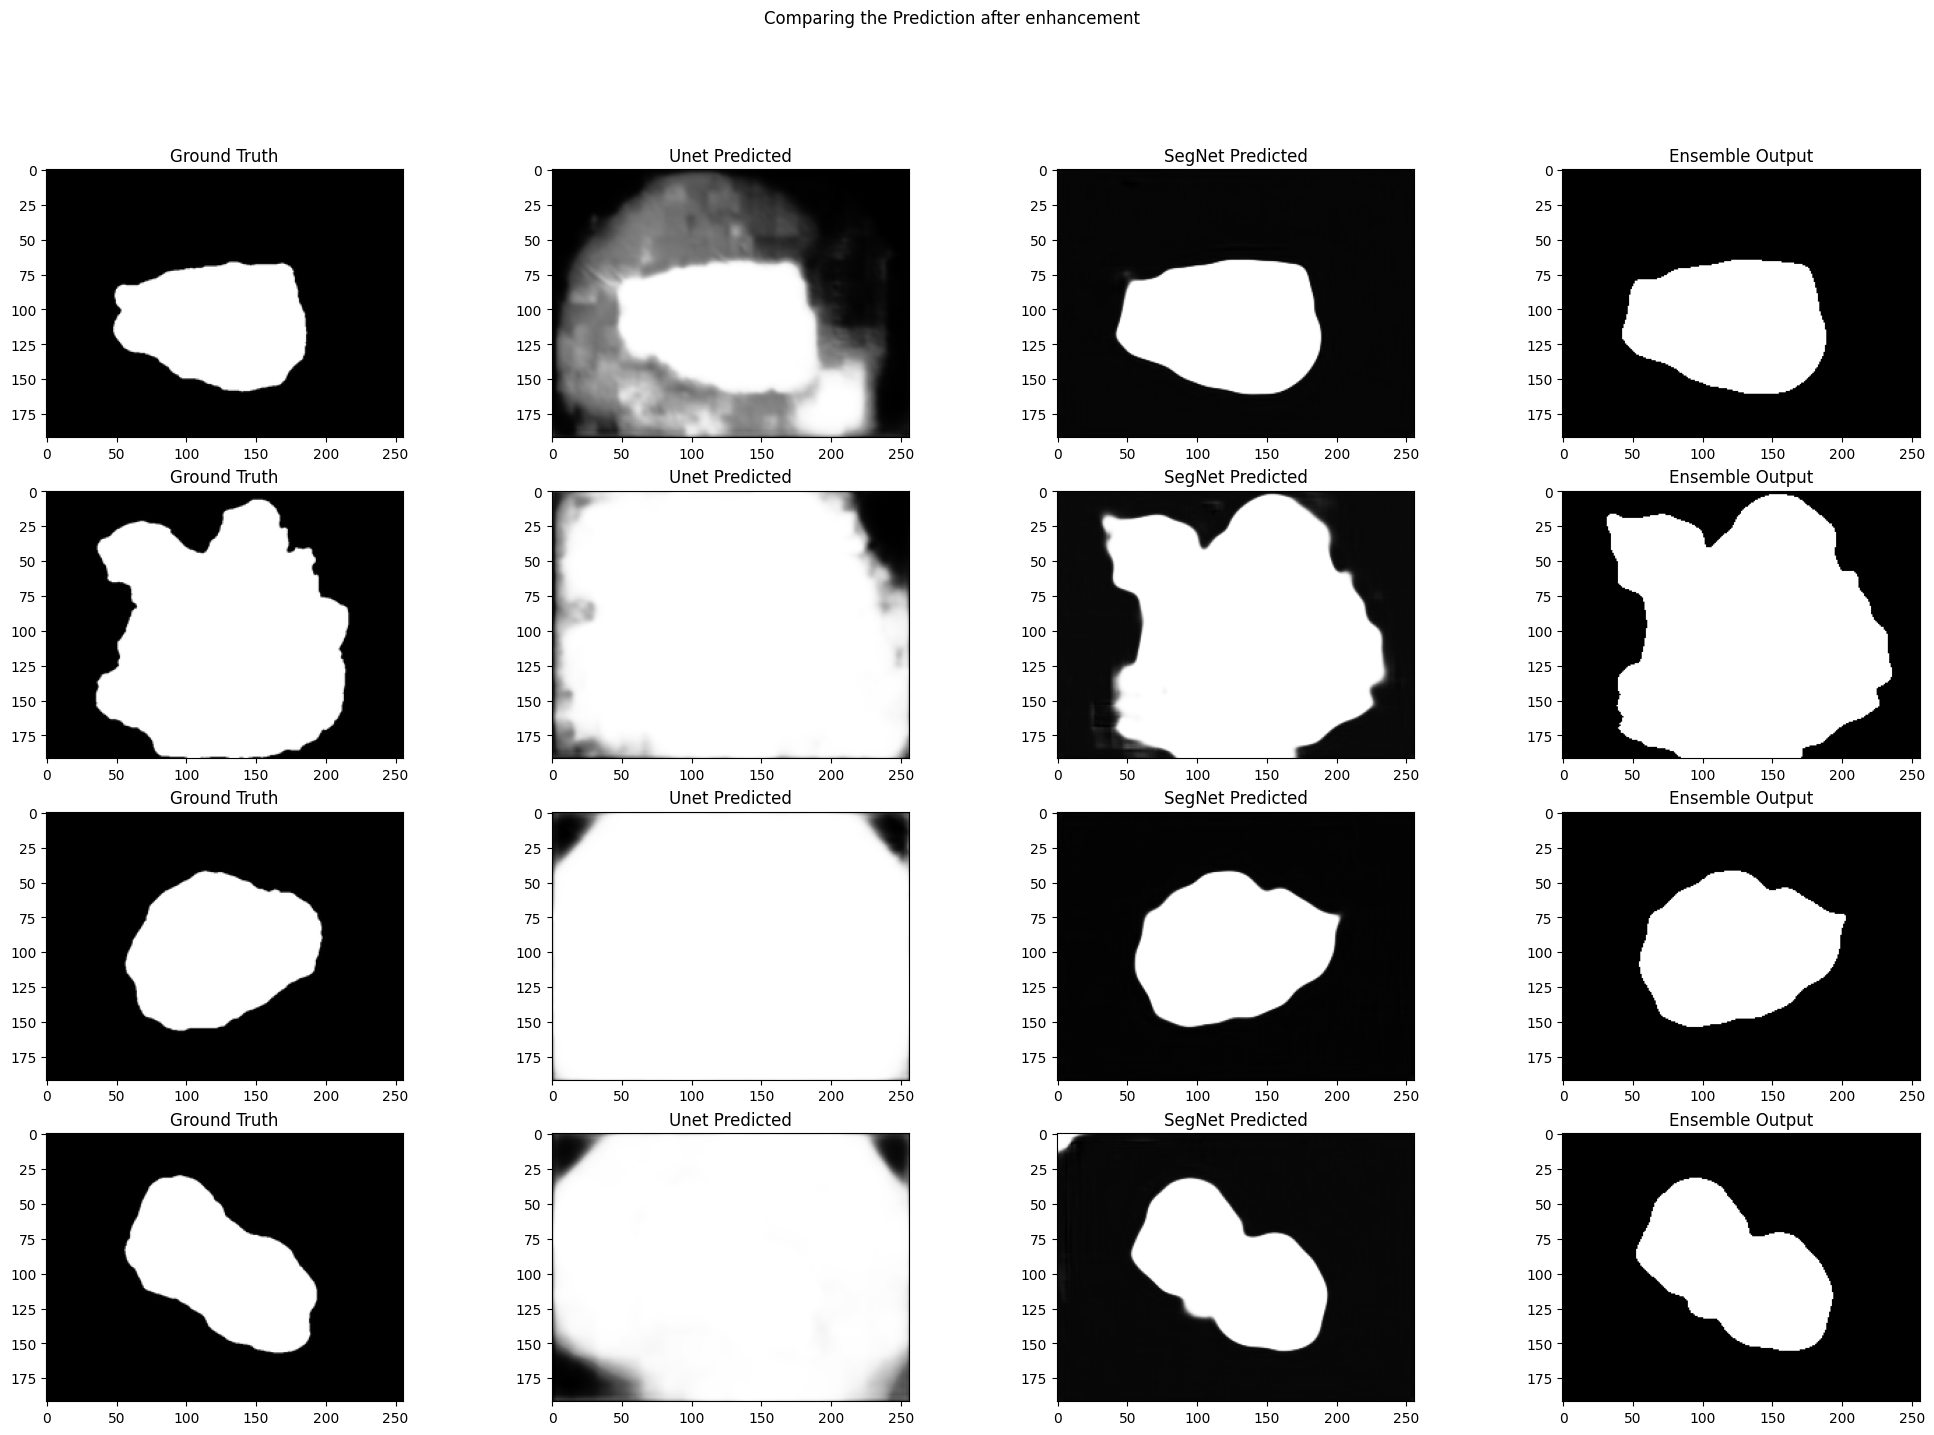

In [75]:
plt.figure(figsize=(25,16))
plt.suptitle('Comparing the Prediction after enhancement')

img_num = 48
plt.subplot(4,4,1)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,2)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,3)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,4)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')


img_num = 370
plt.subplot(4,4,5)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,6)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,7)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,8)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 11
plt.subplot(4,4,9)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,10)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,11)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,12)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 524
plt.subplot(4,4,13)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,14)

img_pred1 = model_unet.predict(x_test[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(x_test[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,15)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,16)
plt.imshow(enhance(x_test[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')
plt.show()